# Speech Recognition with Jasper

This notebook uses [Jasper](https://arxiv.org/abs/1904.03288) from the open source project [NVIDIA/OpenSeq2Seq](https://github.com/NVIDIA/OpenSeq2Seq.git) to transcribe a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install NVIDIA/OpenSeq2Seq

In [10]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/OpenSeq2Seq.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !git checkout e958b7d
  !pip uninstall -y -q pymc3
  !pip install --upgrade joblib
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl librosa python_speech_features sentencepiece
  
  # create eval config
  !cp {project_name}/example_configs/speech2text/jasper10x5_LibriSpeech_nvgrad.py {project_name}/conf.py
  !sed -i -e 's/\/data\/librispeech\/librivox-test-clean/test/' {project_name}/conf.py
  #!sed -i -e 's/# "use_lang/"use_lang/' {project_name}/conf.py
  !echo 'backend = "librosa"' >> {project_name}/conf.py 
  #!cat {project_name}/conf.py
  !echo "wav_filename, wav_filesize, transcript" > {project_name}/test.csv
  !echo "test.wav, UNUSED, UNUSED" >> {project_name}/test.csv
  
import sys
sys.path.append(project_name)
from IPython.display import YouTubeVideo

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
Requirement already up-to-date: joblib in /usr/local/lib/python3.6/dist-packages (0.15.1)


## Download pre-trained Model

In [11]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  
if not exists(join(project_name, 'w2l_log_folder')):
  download_from_google_drive('1gzGT8HoVNKY1i5HNQTKaSoCu7JHV4siR', 'jasper_10x5_dr_sp_nvgrad.zip')
  !unzip jasper_10x5_dr_sp_nvgrad.zip
  !mv checkpoint {project_name}/jasper_log_folder

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2666      0 --:--:-- --:--:-- --:--:--  2684
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2960M    0 2960M    0     0  60.0M      0 --:--:--  0:00:49 --:--:-- 43.9M
Archive:  jasper_10x5_dr_sp_nvgrad.zip
   creating: checkpoint/
  inflating: checkpoint/checkpoint   
  inflating: checkpoint/model.ckpt-439200.data-00000-of-00001  
  inflating: checkpoint/model.ckpt-439200.index  
  inflating: checkpoint/model.ckpt-439200.meta  


## Transcribe Youtube Video

We are going to make speech recognition on the following youtube video:

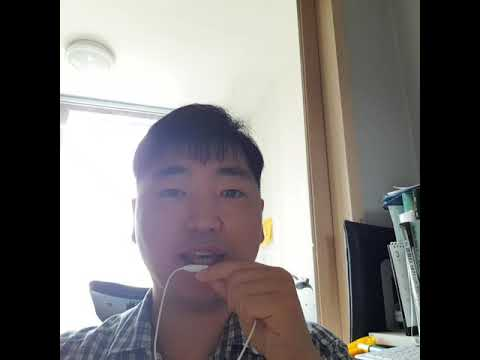

In [12]:
YOUTUBE_ID = 'k3kMQBJepCQ'


YouTubeVideo(YOUTUBE_ID)

Download the above video, convert to a WAV file and do speech recognition:


In [5]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 3.8MB 46.0MB/s 
     |████████████████████████████████| 512kB 43.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=eac1294666b84954eaa967ca4f04a33feb5248e5922aa5b01cf7612d6016cd4f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling te

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
root_path = 'My Drive/Colab Notebooks/'

In [8]:
cd gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [13]:
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 {project_name}/test.wav
!cd {project_name} && python run.py --config_file conf.py --mode=infer --infer_output_file=output.txt --use_horovod=False --num_gpus=1 --batch_size_per_gpu 1

[youtube] k3kMQBJepCQ: Downloading webpage
[download] Destination: downloaded.m4a
[download] 100% of 820.21KiB in 00:01
[ffmpeg] Correcting container in "downloaded.m4a"
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.m4a (pass -k to keep)




-k







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



*** Restoring from the latest checkpoint
*** Loading model from jasper_log_folder/model.ckpt-439200
*** Inference config:
{'batch_size_per_gpu': 1,
 'data_layer': <class 'open_seq2seq.data.speech2text.speech2text.Speech2TextDataLayer'>,
 'data_layer_params': {'backend': 'librosa',
                       'dataset_files': ['test.csv'],
                     

Print out the speech detection result:

In [14]:
!tail -n1 {project_name}/output.txt

test.wav,hello crista krista listen out i needed a solof everything in financial sceptr and health ger sent her but also purchase pup five stuffs out of the energ stock and also health gare no what im sayings you know muturial stock wut doing frigat about the halt care and if you on a purchase apple an he should be over two hundred dollars but lest then two hundred fifty dollars but neath you and a salloff anything out of the helthker stock that you hadpersolles above one hundred dollars and again a need oo a purchased top five staffs out of their enrge stars it is the most
